# TP2 - Topic Modeling

<img src="https://github.com/AntoineSimoulin/m2-data-sciences/blob/master/TP2%20-%20Text%20Mining/figures/figure2.png?raw=1" width="1000">

Le <i>Topic Modeling</i> est une approche statistique qui permet de faire émerger des topics abstraits d'un corpus de documents. 
Cette approche permet également d'analyser la structure du corpus de documents en regroupant ceux qui présentent des topics similaires puis en analysant ces groupes, ou en analysant les caractéristiques des topics identifiés.

La plupart des modèles de <i>Topic Modeling</i> s'appuient sur des hypothèses de modélisations similaires:
* Chaque document est modélisé comme une distribution sur les _topics_ ;
* Chaque _topic_ est modélisé comme une distribution sur les mots du vocabulaire.

On a illustré cette modélisation ci-dessous. Ainsi chaque document est représenté par une distribution sur une variable latente (on dit aussi cachée), les _topics_. Ces derniers ne sont pas "observés" : en pratique chaque document est décrit par une distribution sur les mots du vocabulaire. **L'objectif des modèles de _topics_ est donc de caractériser la forme de cette variable latente.** Nous allons voir plusieurs méthodes et modèles proposant cette caractérisation.

Ci-dessous, on a illustré l'intuition derrière cette modélisation. Chaque document va contenir plusieurs _topics_, par exemple, les transports et les vacances. On retrouvera donc des mots caractéristiques de ces topic: "avion", "plage", "congés" ... Des documents qui abordent des _topics_ proches contiendront donc un vocabulaire proche. Ainsi chaque _topic_ pourra être caractérisé par des mots saillants qui lui sont spécifiques.



<img src="https://github.com/AntoineSimoulin/m2-data-sciences/blob/master/TP2%20-%20Text%20Mining/figures/lda-idee.png?raw=true" width="1000">


In [1]:
%%capture

# ⚠️ Execute only if running in Colab
if 'google.colab' in str(get_ipython()):
  IN_COLAB = True
else:
  IN_COLAB = False

if IN_COLAB:
  !pip install -q scikit-learn==0.23.2 nltk==3.5 unidecode pysrt
  !pip install --no-deps pyLDAvis==3.3.1
  !pip install --no-deps funcy==1.16
  !python3 -m spacy download fr_core_news_md

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer
import numpy as np
import os
from pyLDAvis import sklearn as sklearn_lda
import pickle
import pyLDAvis
import pysrt
import re
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from spacy.lang.fr.stop_words import STOP_WORDS
from tqdm.auto import tqdm
import unidecode
import urllib.request

# IPython automatically reload all changed code
%load_ext autoreload
%autoreload 2

# Inline Figures with matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping, Sequence  # noqa
/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python

In [3]:
# import extrenal modules

repo_url = 'https://raw.githubusercontent.com/AntoineSimoulin/m2-data-sciences/master/'
_ = urllib.request.urlretrieve(repo_url + 'src/plot_dirichlet.py', 'plot_dirichlet.py')

for season in range(1, 9):
  dir = './data/S{:02d}'.format(season)
  if not os.path.exists(dir):
    os.makedirs(dir)
    for episode in range(1, 11):
      try:
        _ = urllib.request.urlretrieve(
            repo_url + 'TP2%20-%20Text%20Mining/sous-titres-got/S{:02d}/E{:02d}.srt'.format(season, episode), 
            './data/S{:02d}/E{:02d}.srt'.format(season, episode))
      except:
        pass

from plot_dirichlet import Dirichlet, draw_pdf_contours

## Latent Semantic Analysis (LSA)

Le modèle Latent Semantic Analysis (LSA) ([Landauer & Dumais, 1997](#landauer-dumais-1997)) cherche à décomposer la matrice de décomposition des documents selon le vocabulaire en deux matrices : une matrice de décomposition des documents selon les topics et une matrice de distribution des topics selon les mots du vocabulaires.

On commencer donc par représenter les documents selon une distribution sur le vocabulaire. Pour cela on utilise le Tf-Idf qui permet de représenter chaque document du corpus comme une distribution sur le vocabulaire, en pratique, un vecteur de la taille du vocabulaire. On peut donc représenter le corpus comme une matrice de taille $(M, V)$ avec $M$ le nombre de documents dans le corpus et $V$ la taille du vocabulaire. Cette représentation est illustrée ci-dessous. 

<img src="https://github.com/AntoineSimoulin/m2-data-sciences/blob/master/TP2%20-%20Text%20Mining/figures/bow.png?raw=true" width="500">

On va ensuite décomposer la matrice en utilisant **décomposition en valeurs singulières** (en anglais Singular Value Decomposition, [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition)). On peut interpréter la SVD comme la généralisation de la diagonalisation d'une matrice normale a des matrices arbitraires. Ainsi une matrice $A$ de taille $n \times m$ peut être factorisée sous la forme $A = U \Sigma V^T$, avec $U$ et $V$ des matrices orthogonales de tailles respectives $m \times m$ et $n \times n$ et $\Sigma$ une martice rectangulaire diagonale de taille $m \times n$. 

En pratique, il est peu commun de décomposer complétement la matrice, on utilise plutôt la <a href="https://en.wikipedia.org/wiki/Singular_value_decomposition#Truncated_SVD"><i>Trucated Singular Value Decomposition</i></a> qui permet de ne calculer que les $t$ premières valeurs singulières. Dans ce cas, on ne considère que les $t$ premières colonnes de la matrice $U$ et les $t$ premières lignes de la matrice $V$. On a ainsi :

$$A_t = U_t \Sigma_t V_t^T$$

Avec $U_t$ de taille $m \times t$ et $V_t$ de taille $n \times t$. Cette décomposition est illustrée ci-dessous.

<img src="https://github.com/AntoineSimoulin/m2-data-sciences/blob/master/TP2%20-%20Text%20Mining/figures/svd-formule.png?raw=true" width="1000">

On illustre ci-dessous l'application de la décomposition à notre matrice Tf-Idf. La matrice $U_t$ apparait comme la matrice <i>document-topic</i> qui définit chaque document comme une distribution de topic. La matrice $V_t$ apparait comme la matrice <i>terme-topic</i> qui définit chaque topic comme une distribution sur le vocabulaire.

<img src="https://github.com/AntoineSimoulin/m2-data-sciences/blob/master/TP2%20-%20Text%20Mining/figures/svd-illustration.png?raw=true" width="1000">

On peut aussi interpréter le <i>Topic Modeling</i> comme une approche de réduction de dimension. En effet, la matrice Tf-Idf a plusieurs défauts : Elle est de grande dimension (la taille du vocabulaire), elle est _sparse_ _i.e._ beaucoup d'entrées sont à zéro, elle est très bruitée et les information sont redondantes selon plusieurs dimensions. La décomposition permet ainsi de la factoriser. Les deux matrices résultantes permetent d'utiliser la similarité cosinus pour comparer simplement des doccuments ou des mots.

## Probabilistic Latent Semantic Analysis (pLSA)

La LSA est une méthode très efficace. Néanmoins en pratique, les topics résultants sont parfois difficiles à interpréter. 
La méthode nécessite un corpus important pour obtenir des résultats pertinents.

La methode de Probabilistic Latent Semantic Analysis (pLSA) remplace ainsi la SVD par une approche probabiliste.
Il s'agit d'un modèle **génératif**, qui permet de générer les documents que l'on observe. 
En pratique il permet de générer la matrice Bag-of-words qui représente le corpus. Le modèle ne tient donc pas compte de l'ordre des mots.

<img src="https://github.com/AntoineSimoulin/m2-data-sciences/blob/master/TP2%20-%20Text%20Mining/figures/plda_principe.png?raw=true" width="1000">


Les modèles graphiques représentent les variables aléatoies comme des noeuds. Les arcs entre les noeuds indiquent les variables potentiellement dépendantes. Les variables observées sont grisées. Dans la figure ci-dessous, les noeuds $ X_{1,...,N}$ sont observés alors que le noeud $Y$ est une variable latente. Dans cet exemple, les variables observées dépendent de cette variable latente. Les rectangles synthétisent la réplication de plusieurs structures. Un rectangle résume donc plusieurs variables $X_n$ avec $n \in N$.

La structure du graph définie les dépendances conditionnelles entre l'ensemble des variables. Par exemple dans le graph ci-dessous, on a $p(Y,X_{1},...,X_{N})=p(Y)\prod _{n=1}^{N}p(X_{n}|Y)$.

<img src="https://github.com/AntoineSimoulin/m2-data-sciences/blob/master/TP2%20-%20Text%20Mining/figures/graphical_model.png?raw=1" width="500">

Le fonctionnement du modèle est détaillé selon la représentation graphique suivante :
* Etant donné un document $d$, un topic $z$ est présent dans le document avec une probabilité $P(z|d)$. 
* Etant donné un topic $z$, un mot est généré selon la probabilité conditionnelle $P(w|z)$.

La probabilité jointe d'observer un mot dans un document s'exprime donc :

$$P(D,W)=P(D)\sum_ZP(Z|D)P(W|Z)$$

Ici, $P(D)$, $P(Z|D)$ et $P(W|Z)$ sont des paramètres du modèle. $P(D)$ peut être  calculé directement à partir du corpus.
$P(Z|D)$ et $P(W|Z)$ sont modélisés par des distributions multinomiales qui peuvent être entrainés par la méthode [EM](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm).

<img src="https://github.com/AntoineSimoulin/m2-data-sciences/blob/master/TP2%20-%20Text%20Mining/figures/plsa.png?raw=true" width="500">

On peut intepréter la probabilité selon la procédure suivante : On commence par un document avec la probabilité $P(D)$, on génère un _topic_ avec la probabilité $P(Z|D)$ puis on génère un mot avec la probabilité $P(W|Z)$. En pratique, on apprend donc les paramètres de notre modèles qui permetent d'expliquer qu mieux le corpus observé comme illustré ci-dessous.

<img src="https://github.com/AntoineSimoulin/m2-data-sciences/blob/master/TP2%20-%20Text%20Mining/figures/plda_inference.png?raw=true" width="1000">

On peut aussi exprimer la probabilité jointe selon la décomposition suivante :

$$P(D,W)=\sum_ZP(Z)P(D|Z)P(W|Z)$$

Dans cette modélisation, on commence par le _topic_ avec $P(Z)$ et on génère ensuite indépendamment le document avec $P(D|Z)$ et le mot avec $P(W|Z)$.

<img src="https://github.com/AntoineSimoulin/m2-data-sciences/blob/master/TP2%20-%20Text%20Mining/figures/plda_process.png?raw=true" width="500">

L'intérêt de cette paramétrisation, c'est qu'elle fait appraitre un parallèle avec la LSA.

La probabilité du topic $P(Z)$ correspond à la matrice diagonale  de la décomposition en valeurs singulièers. La probabilité d'un document en donction du topic $P(D|Z)$ correpond à la matrice document-_topic_  $U$ et la probabilité d'un mot en fonction du _topic_ $P(W|Z)$ correpond à la matricec terme-_topic_ $V$. Les deux approches présentent donc des similarités, la pLSA apporte un traitement statistique des _topics_ et des mots par rapport à la LSA.

<img src="https://github.com/AntoineSimoulin/m2-data-sciences/blob/master/TP2%20-%20Text%20Mining/figures/plsa-formule.png?raw=true" width="500">


## Latent Dirichlet Allocation (LDA)

La pLSA a un certain nombre dee contraintes :
* Il n'y a pas de paramètres pour modéliser $P(D)$, on ne peut donc pas assigner de probabilité à de nouveaux documents
* Le nombre de paramètres grandit linéairement avec le nombre de documents dans le corpus, le modèle est donc sujet à l'_overfitting_.

En pratique, la pLSA  n'est donc pas souvent utilisée, on lui préfère généralement la Latent Dirichlet Allocation (LDA) ([Blei et al., 2001](#blei-2001)). La LDA utilise des prior de dirichlet pour les distributions des documents selon les _topics_ et _topics_ selon les mots, ce qui lui donne de meilleures propriétés de généralisation: on peut généraliser pour de nouveaux documents.


### La distribution de Dirichlet

La [distribution de Dirichlet](https://en.wikipedia.org/wiki/Dirichlet_distribution) est généralement notée $Dir(\alpha)$. Il s'agit d'une famille de lois de probabilités continues pour des variables aléatoires multinomiales. Cette loi (ou encore distribution) est paramétrée par le vecteur ${\bf \alpha}$ de nombres réels positifs. La taille du vecteur ${\bf \alpha}$ indique la dimension de la distribution. Ce type de distribution est souvent utilisée comme distribution à priori dans les modèles Bayésiens. Sans rentrer dans les détails, voici quelques caraactéristiques de la distribution de Dirichlet :

* La distribution est définie sur un simplex de vecteurs positifs dont la somme est égale à 1 
* Sa densité est caractérisée par : $P(\theta |{\overrightarrow {\alpha }})={\frac {\Gamma (\Sigma _{i}\alpha _{i})f}{\Pi _{i}\Gamma (\alpha _{i})}}\Pi _{i}\theta _{i}^{\alpha _{i}-1}$
* En pratique, si toutes les dimensions de ${\bf \alpha}$ ont des valeurs similaires, la distribution est plus étalée. Elle devient plus concentrée pour des valeurs plus importantes de ${\bf \alpha}$.

La distribution est illustrée ci-dessous pour des valeurs des valeurs de ${\bf \alpha}$ 

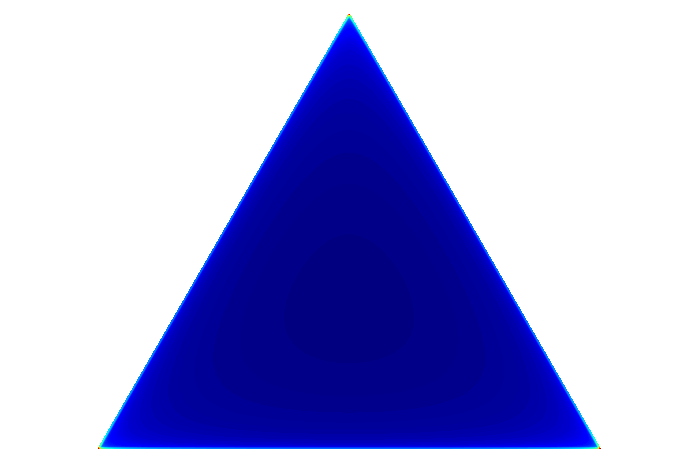

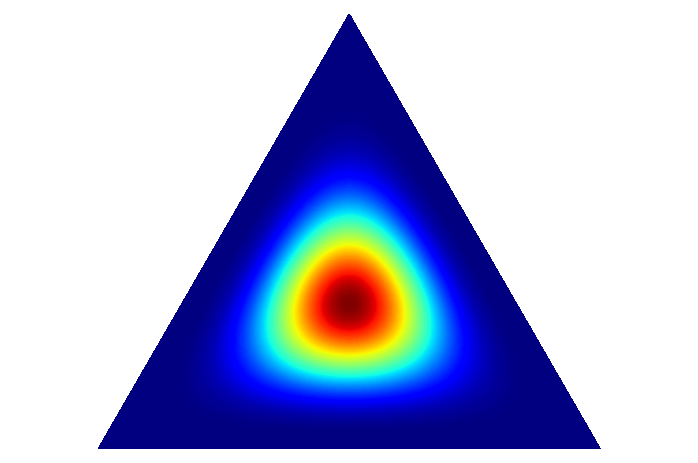

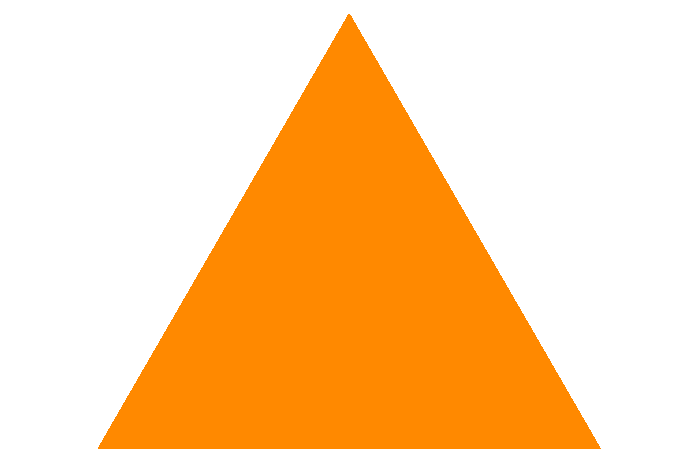

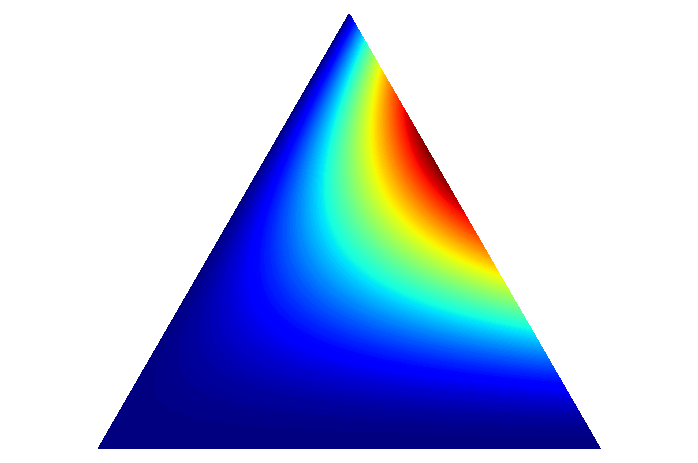

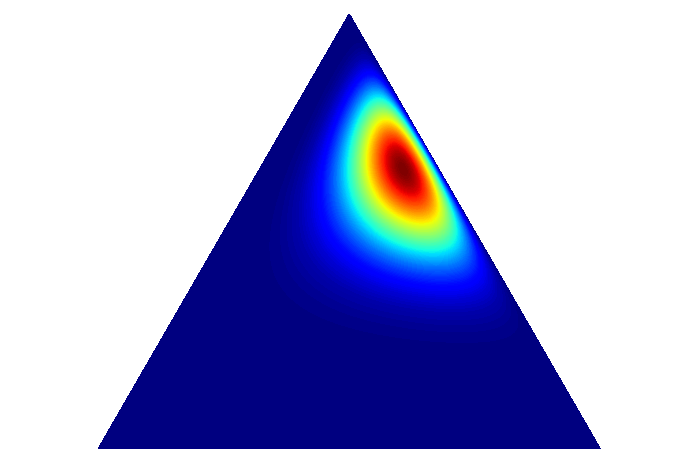

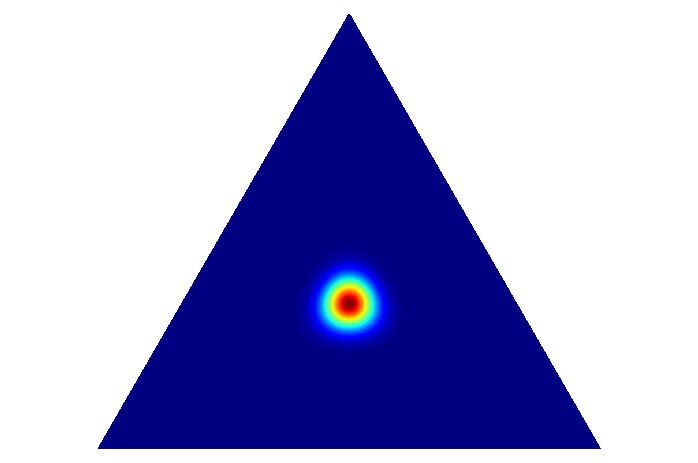

In [4]:
for alpha in [(0.85, 0.85, 0.85), (5, 5, 5), (1, 1, 1), (1, 2, 3), (2, 5, 10), (50, 50, 50)]:
    draw_pdf_contours(Dirichlet(alpha))

Cette distribution a des avantages pratiques. En particulier, on s'attend à ce que les documents du corpus contiennent un _topic_ "majoritaire". Ils ne sont pas générés selon une distribution 25% vacances, 25% sport, 25% élections, 25% transports mais plutôt des distributions du type 85% vacances, 5% sport, 5% élections, 5% transports. Ces distributions vont donc attribué un poids important à un certain _topic_. C'est justement ce que permet de réaliser la distribution de Dirichlet avec de faibles valeurs de $\alpha$.

La représentation garphique du modèle est proposée ci-dessous. La LDA suppose le procéssus génératif suivant pour chaque document $W$ dans le corpus $D$.


> 1. On choisit $\theta \sim Dir(\alpha )$
> 2. Pour chaque document dans le corpus:
>     * Pour chacun des $N$ mots $w_{n}$ dans le document :
>        * on génère un topic $z_{n}\sim Multinomial(\theta )$
>        * on génère un mot $w_{n}$ $p(w_{n}|z_{n},B)$ selon une loi multinimoale conditionnée par le topic $z_{n}$.


Our goal here is to estimate parameters φ, θ to maximize p(w; α, β). The main advantage of LDA over pLSA is that it generalizes well for unseen documents.

<img src="https://github.com/AntoineSimoulin/m2-data-sciences/blob/master/TP2%20-%20Text%20Mining/figures/lda_graph.png?raw=true" width="700">

## 3. Utilisation des librairies

On va chercher à analyser les thèmes de la Série Game Of Thrones. On utilise pour ça les sous-titres de l'ensemble des saisons qui ont été récupérés sur le site https://www.sous-titres.eu/series/game_of_thrones.html.

In [5]:
def create_subtitle_file_dict(subtitles_dir):
    "Retourne les chemins vers les fichiers de sous titres"
    subtitles_file_path = {}
    for path, _, files in os.walk(subtitles_dir):
        for name in files:
            episode_name = '_'.join([os.path.basename(path), name.split('.')[0]])
            subtitles_file_path[episode_name] = os.path.join(path, name)
    return subtitles_file_path

def parse_srt_file(srt_file, encoding='iso-8859-1'):
    "Lit un ficher de sous titres au format rst"
    subs = pysrt.open(srt_file, encoding=encoding)
    text = ' '.join([' '.join(sub.text.split('\n')) for sub in subs])
    return text

def create_corpus(subtitles_file_path):
    "Créer un corpus à partir de tous les fichiers rst dans un dossier"
    corpus = []
    for _, v in subtitles_file_path.items():
        if v.endswith('srt'):
            corpus.append(parse_srt_file(v))
    return corpus

def split_episodes(corpus):
    "split chaque episode en un sous épisode de 400 mots."
    corpus_split = []
    for episode in corpus:
        episode_words = episode.split()
        i = 0
        while i < len(episode_words):
            corpus_split.append(' '.join(episode_words[i:i+400]))
            i+=400
    return corpus_split

In [6]:
subtitles_file_path = create_subtitle_file_dict('./data/')

In [7]:
episode_1_txt = parse_srt_file(subtitles_file_path['S01_E01'])

In [8]:
print(episode_1_txt[:100])

Doucement. Que croyais-tu ? Ce sont des sauvages. L'un vole une chèvre à l'autre, et ils finissent p


In [9]:
corpus = create_corpus(subtitles_file_path)
corpus = split_episodes(corpus)

In [10]:
len(corpus)

690

In [11]:
corpus[0][:100]

'Vous avez connu des jours meilleurs. Une autre visite ? Vous êtes mon dernier ami. Non, non, beaucou'

<hr>
<div class="alert alert-info" role="alert">
    <p><b>📝 Exercice :</b> Nettoyer le corpus pour enlever les accents, mettre le texte en minuscule, enlever la ponctuation et les doubles espaces. Eventuellement pour le stemming.</p>
</div>
<hr> 

In [12]:
stemmer = FrenchStemmer()

def clean_corpus(corpus):
    for i in range(len(corpus)):
        corpus[i] = unidecode.unidecode(corpus[i])
        corpus[i] = re.sub(r'[^\w\s]', ' ', corpus[i])
        corpus[i] = corpus[i].lower()
        corpus[i] = re.sub(r'\s{2,}', ' ', corpus[i])
        # corpus[i] = ' '.join([stemmer.stem(x) for x in corpus[i].split()])
    return corpus

In [13]:
corpus = clean_corpus(corpus)

In [14]:
corpus[0][:100]

'vous avez connu des jours meilleurs une autre visite vous etes mon dernier ami non non beaucoup d au'

In [15]:
len(corpus)

690

In [16]:
def tokenize_corpus(corpus):
    tokens = []
    for sentence in corpus.split('\n'):
        tokens.append(nltk.word_tokenize(sentence))
    return tokens

In [17]:
sentence_length = [len(x.split()) for x in corpus]

In [18]:
np.mean(sentence_length), np.std(sentence_length)

(394.3985507246377, 76.07669088788185)

<hr>
<div class="alert alert-info" role="alert">
    <p><b>📝 Exercice :</b> Vectorizer le corpus en utilisant la méthode Bag-Of-Words.</p>
</div>
<hr> 

In [19]:

# Initialise the count vectorizer
count_vectorizer = CountVectorizer(max_features=2000,
                                   stop_words=STOP_WORDS,
                                   max_df=0.9,
                                   min_df=20)

count_data = count_vectorizer.fit_transform(corpus)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['qu', 'quelqu'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [20]:
len(corpus)

690

In [21]:
# Faire varier les paramètres ci-dessous
number_topics = 15
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)

LatentDirichletAllocation(n_components=15, n_jobs=-1)

In [22]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [23]:
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
adaptation brothers titrage dubbing blandine menard maville clotilde qu garde

Topic #1:
qu ca roi ser jamais sais mere lord reine mort

Topic #2:
nord roi qu stark morts hommes armee jon winterfell garde

Topic #3:
roi avez qu joffrey tyrion nom fils homme mort lannister

Topic #4:
qu avez ca pere reine etes jamais cersei dragons veux

Topic #5:
qu avez etes reine maitre faire oui hommes jamais homme

Topic #6:
theon pere robb messire qu guerre greyjoy jamais ete stark

Topic #7:
lord qu stark pere roi fils ici oui lannister avez

Topic #8:
stark lannister tuer avez qu mere tue hommes nom petite

Topic #9:
roi stannis lannister etes pere qu fils trone robert homme

Topic #10:
ca qu veux fille roi epee sansa tue frere faire

Topic #11:
qu ca mur ici mance jon allez hommes garde faut

Topic #12:
qu ca sais homme mort vie nuit pere oui jamais

Topic #13:
avez mere qu grand reine roi dieux loras voir etes

Topic #14:
stark qu ca winterfell nord etes hodor 

## 4. Visualisation

In [24]:
%%time

LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer, mds='mmds')

CPU times: user 302 ms, sys: 32.7 ms, total: 334 ms
Wall time: 1.78 s


In [25]:
with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
    
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

In [26]:
pyLDAvis.display(LDAvis_prepared)

<hr>
<div class="alert alert-info" role="alert">
    <p><b>📝 Exercice :</b> Faire varier le paramètre Lambda et justifier de son impact.</p>
</div>
<hr>

On peut définir la pertinence d'un mot $\omega$ dans un topic $\tau$ comme la combinaison convexe :
$$\mathcal{R_\lambda}\left(\omega,\tau\right) = \lambda \log\left(\mathbb{P}\left(\omega \mid \tau\right)\right) +
\left(1-\lambda\right)\log\left(\frac{\mathbb{P}\left(\omega \mid \tau\right)}{\mathbb{P}\left(\omega\right)}\right),$$
où $\lambda$ est un paramètre de pondération. Ce dernier va donc influer la pondération des termes associés à chaque topics (partie droite de la visualisation). Par contre, il n'a pas d'impact sur les distances inter-topics (partie gauche de la visualisation)

* Quand $\lambda$ est proche de 1, on a : $\mathcal{R_\lambda}(w|\tau) \approx \mathbb{P}(w|\tau)$. La pertinence se résume alors à la probabilité qu'un mot $w$ apparaisse dans un _topic_ donné $t$. les termes sont ordonnés selon leur probabilité conditionnelle dans un topic. Des tokens assez généraux comme "et", "que", "ça" ou "ici" apparaissent souvent en haut des classements car ils ont une fréquence très élevée dans tous les topics.

* Lorsque $\lambda$ est proche de 0, on a : $\mathcal{R_\lambda}(w|\tau) \approx \frac{\mathbb{P}(w|\tau)}{\mathbb{P}(w)}$. Les termes sont ordonnés par leur <i>lift</i> qui représente le rapport entre la probabilité conditionnelle des mots dans un _topic_ par leur probabilité d'apparition à l'échelle du corpus. Les mots sélectionnés pour décrire chaque topic ont des fréquences plus faibles et s'ils sont plus caractéristiques peuvent aussi parfois sembler plus marginaux comme par exemple "courageux", "voler", "tenus". Néanmoins les mots génériques sont filtrés.

* On peut aussi trouver un équilibre entre la fréquence "brute" et le ratio en manipulant le paramètre Lambda afin de faire apparaître en haut du classement les termes les plus pertinents au topic sans donner une trop grande importance aux exceptions statistiques. Par exemple en fixant le paramètre lambda à une valeur entre 0.2 et 0.4. On filtre ainsi les mots génériques sans attribuer un poids trop important aux expressions plus ésotériques.

<hr>
<div class="alert alert-info" role="alert">
    <p><b>📝 Exercice :</b> Faire varier le préprocessing,en particulier la stemmatization. Analyser l'impact sur l'analyse des clusters.</p>
</div>
<hr>

In [27]:
import spacy

In [28]:
nlp = spacy.load('fr_core_news_md')
stemmer = FrenchStemmer()

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


In [29]:
def clean_corpus_(corpus, stem=False, lem=False):
    for i in range(len(corpus)):
        corpus[i] = unidecode.unidecode(corpus[i])
        corpus[i] = re.sub(r'[^\w\s]', ' ', corpus[i])
        corpus[i] = corpus[i].lower()
        corpus[i] = re.sub(r'\s{2,}', ' ', corpus[i])
        if stem:
            corpus[i] = ' '.join([stemmer.stem(x) for x in corpus[i].split()])
        if lem and not stem:
            doc = nlp(str(corpus[i] ))
            corpus[i] = ' '.join([token.lemma_ for token in doc])
    return corpus

clean_corpus = clean_corpus_(corpus, stem=True)

clean_corpus_split = []
for episode in clean_corpus:
    episode_words = episode.split()
    i = 0
    while i < len(episode_words):
        clean_corpus_split.append(' '.join(episode_words[i:i+400]))
        i+=400
        
count_data = count_vectorizer.fit_transform(clean_corpus_split)

lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer, mds='mmds')
pyLDAvis.display(LDAvis_prepared)

La lemmatisation et la stemmatisation permettent de réduire le vocabulaire et de mieux le "spécifier". Pour la stemmatisation, on supprime la fin des mots. Les termes "garde" et "garder" seront associés à la même racine "gard".

Visuellement, les topics semblent moins bien séparés (partie de gauche de la visualisation). A priori ils partagent plus de vocabulaire. La stemmatisation accentue la fréquence de mots déjà très représentés ("ca", "qu" ...) que l'on ne souhaite pas identifier. Cette pondération se fait au dépend de termes plus caractéristiques comme le token "dragon" qui disparait du topic 9. Par ailleurs la stemmatisation est un procéssus assez destructeur et certaines racines sont difficiles à rattacher à leur terme d'origine. Par exemple "vis" pourrait se rapporter à "viser" ou simplement à la conjugaison du verbe "voir".

Sans appliquer la stemmatisation, on trouvait peu de formes alternatives du même mots dans les termes associés à chaque topic. Cette dernière apparait donc comme assez peu opportune car elle ne favorise pas la lisibilité des topics.

In [32]:
%%capture

clean_corpus = clean_corpus_(corpus, lem=True)

clean_corpus_split = []
for episode in clean_corpus:
    episode_words = episode.split()
    i = 0
    while i < len(episode_words):
        clean_corpus_split.append(' '.join(episode_words[i:i+400]))
        i+=400
        
count_data = count_vectorizer.fit_transform(clean_corpus_split)

lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer, mds='mmds')

In [33]:
pyLDAvis.display(LDAvis_prepared)

A l'instar le la stemmatisation, la lemmatisation cherche à standardiser le vocabulaire. Néanmoins le procéssus est plus subtile. On ne supprime pas simplement la fin des mots mais identifie leur "lem" grâce au contexte du mots dans la phrase et à une ontologie. A première vue, on constate des effets similaires à ceux obtenus avec la stemmatisation : les topics semblent moins bien séparés sur la visualisation des distances inter-topics. Néanmoins, les termes les plus caractéristiques associés à chaque topic semblent plus lisibles car le processus est moins "destructeur". Le mot dragon apparait à nouveau dans le topic 9. Finalement la lemmatisation semble un bon équilibre pour standardiser le vocabulaire.

<hr>
<div class="alert alert-info" role="alert">
    <p><b>📝 Exercice :</b> Etudier l'impact des Stop Words sur les topics.</p>
</div>
<hr>

In [31]:
# Initialise the count vectorizer
count_vectorizer = CountVectorizer(max_features=2000,
                                   stop_words=None,
                                   max_df=0.9,
                                   min_df=20)

count_data = count_vectorizer.fit_transform(clean_corpus_split)

lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer, mds='mmds')
pyLDAvis.display(LDAvis_prepared)

Les stops words sont des mots souvent très fréquents mais assez peu caractéristiques (prépositions, articles, pronoms personnels ...). Lorsqu'on ne les filtre pas, ils viennent polluer la caractérisation des topics puisqu'on les retrouve assez systématiquement dans les mots caractéristiques. Ce bruitage des topics affecte également la distinction inter topics puisque ces derniers sont moins bien séparés. Il semble donc plus pertinents de filtrer les stop words pour favoriser l'interprétabilité des topics.

## References

> <div id="landauer-dumais-1997">Landauer, Thomas K. et al. <a href=http://lsa.colorado.edu/papers/dp1.LSAintro.pdf>An introduction to latent semantic analysis.</a> Discourse Processes 25 (1998): 259-284.</div>

> <div id="blei-2001"> David M. Blei, Andrew Y. Ng, Michael I. Jordan: <a href=https://ai.stanford.edu/~ang/papers/nips01-lda>Latent Dirichlet Allocation.</a> NIPS 2001: 601-608</div>
 
> <div id="alghamdi-2001"> Rubayyi Alghamdi and Khalid Alfalqi: <a href=http://dx.doi.org/10.14569/IJACSA.2015.060121>A Survey of Topic Modeling in Text Mining.</a> International Journal of Advanced Computer Science and Applications(IJACSA), 6(1), 2015</div>

> <div id="sievert-2014"> Sievert, Carson, and Kenneth Shirley. <a href="https://aclanthology.org/W14-3110.pdf">LDAvis: A method for visualizing and interpreting topics.</a> Proceedings of the workshop on interactive language learning, visualization, and interfaces. 2014.

> <div id="chuang-2012"> Chuang, Jason, Christopher D. Manning, and Jeffrey Heer. <a href="https://dl.acm.org/doi/10.1145/2254556.2254572">Termite: Visualization techniques for assessing textual topic models.</a> Proceedings of the international working conference on advanced visual interfaces. 2012.

**Copyright 2021 Antoine SIMOULIN.**

<i>Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

Icons made by <a href="https://www.flaticon.com/authors/freepik" title="Freepik">Freepik</a>, <a href="https://www.flaticon.com/authors/pixel-perfect" title="Pixel perfect">Pixel perfect</a>, <a href="https://www.flaticon.com/authors/becris" title="Becris">Becris</a>, <a href="https://www.flaticon.com/authors/smashicons" title="Smashicons">Smashicons</a>, <a href="https://www.flaticon.com/authors/srip" title="srip">srip</a>, <a href="https://www.flaticon.com/authors/adib-sulthon" title="Adib">Adib</a>, <a href="https://www.flaticon.com/authors/flat-icons" title="Flat Icons">Flat Icons</a> and <a href="https://www.flaticon.com/authors/dinosoftlabs" title="Pixel perfect">DinosoftLabs</a> from <a href="https://www.flaticon.com/" title="Flaticon"> www.flaticon.com</a></i>